In [2]:
import pandas as pd

DF = pd.read_csv('https://raw.githubusercontent.com/rusita-ai/pyData/master/Bike_Sharing_Demand.csv')
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [2]:
DF.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# 1, Data Preprocessing

## 1) 'String' -> 'Date'
* year, month, day, hour 추출

In [3]:
DF['datetime'] = DF.datetime.apply(pd.to_datetime)

DF['year'] = DF.datetime.apply(lambda x : x.year)
DF['month'] = DF.datetime.apply(lambda x : x.month)
DF['day'] = DF.datetime.apply(lambda x : x.day)
DF['hour'] = DF.datetime.apply(lambda x : x.hour)

DF.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


## 2) Drop Columns

In [4]:
drop_columns = ['datetime','casual','registered']
DF.drop(drop_columns, axis=1, inplace=True)
DF.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


In [5]:
X = DF[['season',	'holiday',	'workingday',	'weather',	'temp',	'atemp',	'humidity',	'windspeed','year',	'month',	'day',	'hour']]
y = DF['count']

# 2, 탐색적 데이터 분석

## 1) pairplot

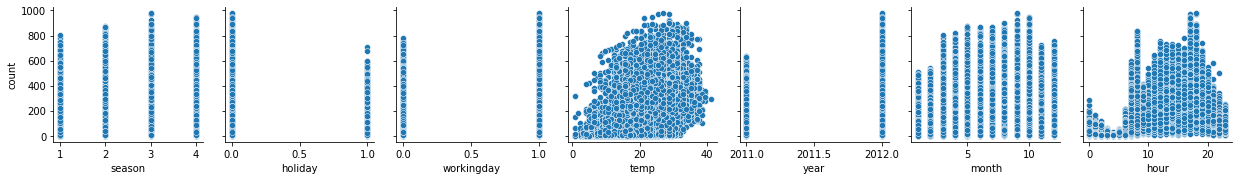

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(DF, y_vars=['count'],
             x_vars = ['season','holiday','workingday','temp','year','month','hour'])
plt.show()

## 2) Feature Importance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


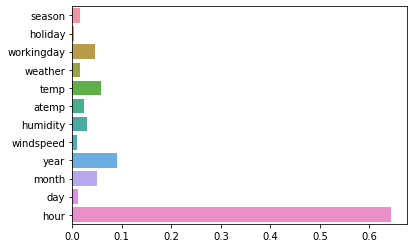

In [18]:
# Decision Model

from sklearn.tree import DecisionTreeRegressor

Model_1 = DecisionTreeRegressor(max_depth = None, criterion = 'mse')
Model_1.fit(X, y)



Model_1.feature_importances_

sns.barplot(Model_1.feature_importances_,
            ['season',	'holiday',	'workingday',	'weather',	'temp',	'atemp',	'humidity',	'windspeed','year',	'month',	'day',	'hour'])
plt.show()

# 3, Multivariate Regression

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

## 1) Lasso 

### (1) 모델링 함수

In [7]:
def multiReg(model_name, X, y, dg, ap=0.5 ):
  # split
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =2045)

  # poly
  poly = PolynomialFeatures(degree=dg, include_bias = False)
  X_train_poly = poly.fit_transform(X_train)
  X_test_poly = poly.fit_transform(X_test)

  # model
  model_mr = Lasso(normalize=True, alpha = ap)
  model_mr.fit(X_train_poly, y_train)

  # evaluate
  m_s_e = mean_squared_error(y_test, model_mr.predict(X_test_poly))
  mse = np.sqrt(m_s_e)

  return {'model_id':model_name, '차수':dg, 'MSE':mse, 'alpha':ap}



In [9]:
X = DF[['season',	'holiday',	'workingday',	'weather',	'temp',	'atemp',	'humidity',	'windspeed','year',	'month',	'day',	'hour']]
y = DF['count']

DF_res_mr = pd.DataFrame(data=None, columns = ['model_id','차수','MSE','alpha'])

In [10]:
%%time
index = 1
for n in [1,2,3]:
  model_name = 'MR-'+str(index)
  index += 1
  res = multiReg(model_name, X, y, dg=n )
  print(res)
  DF_res_mr = DF_res_mr.append(res, ignore_index=True)

{'model_id': 'MR-1', '차수': 1, 'MSE': 166.25218752791096, 'alpha': 0.5}
{'model_id': 'MR-2', '차수': 2, 'MSE': 161.1294526376966, 'alpha': 0.5}
{'model_id': 'MR-3', '차수': 3, 'MSE': 160.93003452226176, 'alpha': 0.5}
CPU times: user 2.65 s, sys: 304 ms, total: 2.96 s
Wall time: 2.7 s


In [11]:
%%time
for n in [5]:
  model_name = 'MR-'+str(index)
  index += 1
  res = multiReg(model_name, X, y, dg=n )
  print(res)
  DF_res_mr = DF_res_mr.append(res, ignore_index=True)

{'model_id': 'MR-4', '차수': 5, 'MSE': 160.92152796842555, 'alpha': 0.5}
CPU times: user 32.7 s, sys: 492 ms, total: 33.2 s
Wall time: 33.1 s


In [12]:
%%time
for n in [7]:
  model_name = 'MR-'+str(index)
  index += 1
  res = multiReg(model_name, X, y, dg=n )
  print(res)
  DF_res_mr = DF_res_mr.append(res, ignore_index=True)

{'model_id': 'MR-5', '차수': 7, 'MSE': 160.90891285014962, 'alpha': 0.5}
CPU times: user 4min 11s, sys: 2.87 s, total: 4min 14s
Wall time: 4min 14s


#### 9차항은 ram이 따라가지 못해서 세션 다운.

### (2) alpha 조정

In [13]:
DF_res_mr.sort_values(by='MSE')

,model_id,차수,MSE,alpha
4,MR-5,7,160.908913,0.5
3,MR-4,5,160.921528,0.5
2,MR-3,3,160.930035,0.5
1,MR-2,2,161.129453,0.5
0,MR-1,1,166.252188,0.5


In [15]:
a = [0.2, 0.4]
for n in a:
  model_name = 'MR_ap-'+str(index)
  index += 1
  res = multiReg(model_name, X, y, dg=7, ap=n )
  print(res)
  DF_res_mr = DF_res_mr.append(res, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36163.12014618516, tolerance: 26596.237288326804
  positive)


{'model_id': 'MR_ap-6', '차수': 7, 'MSE': 135.09378256934139, 'alpha': 0.2}
{'model_id': 'MR_ap-7', '차수': 7, 'MSE': 154.71098651469063, 'alpha': 0.4}


### (2) MSE 비교

In [16]:
DF_res_mr_sort = DF_res_mr.sort_values(by='MSE', ascending=True)
DF_res_mr_sort

,model_id,차수,MSE,alpha
5,MR_ap-6,7,135.093783,0.2
6,MR_ap-7,7,154.710987,0.4
4,MR-5,7,160.908913,0.5
3,MR-4,5,160.921528,0.5
2,MR-3,3,160.930035,0.5
1,MR-2,2,161.129453,0.5
0,MR-1,1,166.252188,0.5


## 2) Multivariate Regression

### 모델링 함수

In [17]:
def multiReg(model_name, X, y, dg ):
  # split
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =2045)

  # poly
  poly = PolynomialFeatures(degree=dg, include_bias = False)
  X_train_poly = poly.fit_transform(X_train)
  X_test_poly = poly.fit_transform(X_test)

  # model
  model_mr = LinearRegression(normalize=True, n_jobs=-1)
  model_mr.fit(X_train_poly, y_train)

  # evaluate
  m_s_e = mean_squared_error(y_test, model_mr.predict(X_test_poly))
  mse = np.sqrt(m_s_e)

  return {'model_id':model_name, '차수':dg, 'MSE':mse}



### (1) X = DF[['season','workingday','hour']]

In [18]:
X = DF[['season','workingday','hour']]
y= DF['count']
DF_res_mr_bs = pd.DataFrame(data=None, columns = ['model_id','차수','MSE'])

In [19]:
index = 1
for n in [1,2,3,5,7]:
  model_name = 'MR_swh-'+str(index)
  index += 1
  res = multiReg(model_name, X, y, dg=n )
  print(res)
  DF_res_mr_bs = DF_res_mr_bs.append(res, ignore_index=True)

{'model_id': 'MR_swh-1', '차수': 1, 'MSE': 164.71194788749682}
{'model_id': 'MR_swh-2', '차수': 2, 'MSE': 144.0411925980319}
{'model_id': 'MR_swh-3', '차수': 3, 'MSE': 134.66956671094806}
{'model_id': 'MR_swh-4', '차수': 5, 'MSE': 127.62831345080842}
{'model_id': 'MR_swh-5', '차수': 7, 'MSE': 111.86989262230361}


### (2) X = DF[['weather','temp']]

In [20]:
X = DF[['weather','temp']]
y= DF['count']

In [21]:

for n in [1,2,3,5,7]:
  model_name = 'MR_wt-'+str(index)
  index += 1
  res = multiReg(model_name, X, y, dg=n )
  print(res)
  DF_res_mr_bs = DF_res_mr_bs.append(res, ignore_index=True)

{'model_id': 'MR_wt-6', '차수': 1, 'MSE': 167.3957064692763}
{'model_id': 'MR_wt-7', '차수': 2, 'MSE': 167.328789419818}
{'model_id': 'MR_wt-8', '차수': 3, 'MSE': 167.18296123789725}
{'model_id': 'MR_wt-9', '차수': 5, 'MSE': 166.73494244456896}
{'model_id': 'MR_wt-10', '차수': 7, 'MSE': 166.74700809049529}


### (3) X = DF[['season','workingday','hour','weather','temp']]

In [22]:
X = DF[['season','workingday','hour','weather','temp']]
y= DF['count']

In [23]:
for n in [1,2,3,5,7]:
  model_name = 'MR_swhwt-'+str(index)
  index += 1
  res = multiReg(model_name, X, y, dg=n )
  print(res)
  DF_res_mr_bs = DF_res_mr_bs.append(res, ignore_index=True)

{'model_id': 'MR_swhwt-11', '차수': 1, 'MSE': 154.3150222809306}
{'model_id': 'MR_swhwt-12', '차수': 2, 'MSE': 135.48363119316272}
{'model_id': 'MR_swhwt-13', '차수': 3, 'MSE': 127.53542600510778}
{'model_id': 'MR_swhwt-14', '차수': 5, 'MSE': 118.26079753089451}
{'model_id': 'MR_swhwt-15', '차수': 7, 'MSE': 102.09332905378643}


### (4) X = all

In [24]:
X = DF[['season',	'holiday',	'workingday',	'weather',	'temp',	'atemp',	'humidity',	'windspeed','year',	'month',	'day',	'hour']]
y= DF['count']
%%time

for n in [1,2,3,5,7]:
  model_name = 'MR_all-'+str(index)
  index += 1
  res = multiReg(model_name, X, y, dg=n )
  print(res)
  DF_res_mr_bs = DF_res_mr_bs.append(res, ignore_index=True)

{'model_id': 'MR_all-16', '차수': 1, 'MSE': 144.3308883322238}
{'model_id': 'MR_all-17', '차수': 2, 'MSE': 123.89424608098831}
{'model_id': 'MR_all-18', '차수': 3, 'MSE': 116.57023848149502}
{'model_id': 'MR_all-19', '차수': 5, 'MSE': 73412467962.74333}
{'model_id': 'MR_all-20', '차수': 7, 'MSE': 47389.39727168527}


#### 5차항부터는 overfitting

### (5) MSE 비교

In [25]:
DF_res_mr_bs_sort = DF_res_mr_bs.sort_values(by='MSE', ascending=True)
DF_res_mr_bs_sort

,model_id,차수,MSE
14,MR_swhwt-15,7,1.020933e+02
4,MR_swh-5,7,1.118699e+02
17,MR_all-18,3,1.165702e+02
13,MR_swhwt-14,5,1.182608e+02
16,MR_all-17,2,1.238942e+02
12,MR_swhwt-13,3,1.275354e+02
3,MR_swh-4,5,1.276283e+02
2,MR_swh-3,3,1.346696e+02
11,MR_swhwt-12,2,1.354836e+02
1,MR_swh-2,2,1.440412e+02


# 4, Random Forest

## 1) Regression

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

### 모델링 함수

In [12]:
def randomForest(model_name, X, y, n_est, mf='auto', md=None):
  # split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2045)

  # model
  model_rfr = RandomForestRegressor(n_estimators = n_est, max_features = mf, max_depth =md, criterion = 'mse', n_jobs= -1, random_state=2045)
  model_rfr.fit(X_train, y_train)

  # evaluate
  m_s_e = mean_squared_error(y_test, model_rfr.predict(X_test))
  mse = np.sqrt(m_s_e)

  return {'model_id':model_name, 'n_estimators':n_est, 'max_features':mf, 'max_depth':md, 'MSE':mse}

In [28]:
DF_res_rfr = pd.DataFrame(data=None, columns = ['model_id','n_estimators','max_features','max_depth','MSE'])

In [9]:
X = DF[['season',	'holiday',	'workingday',	'weather',	'temp',	'atemp',	'humidity',	'windspeed','year',	'month',	'day',	'hour']]
y = DF['count']

### (1) n_est 조정

In [45]:
# DF_res_rfr.drop(index=range(0,4), inplace=True)
# DF_res_rfr

,model_id,n_estimators,max_features,max_depth,MSE


In [30]:
%%time
a = [100, 300, 500, 1000]
index = 1
for n in a:
  model_name = 'RFR-'+str(index)
  index += 1
  res = randomForest(model_name, X, y, n_est=n)
  print(res)
  DF_res_rfr = DF_res_rfr.append(res, ignore_index=True)

{'model_id': 'RFR-1', 'n_estimators': 100, 'max_features': 'auto', 'max_depth': None, 'MSE': 42.81171267315258}
{'model_id': 'RFR-2', 'n_estimators': 300, 'max_features': 'auto', 'max_depth': None, 'MSE': 42.787661076721776}
{'model_id': 'RFR-3', 'n_estimators': 500, 'max_features': 'auto', 'max_depth': None, 'MSE': 42.7657728440677}
{'model_id': 'RFR-4', 'n_estimators': 1000, 'max_features': 'auto', 'max_depth': None, 'MSE': 42.775752410185625}
CPU times: user 1min 26s, sys: 1.24 s, total: 1min 28s
Wall time: 46.2 s


In [31]:
%%time
a = [2000, 3000]

for n in a:
  model_name = 'RFR-'+str(index)
  index += 1
  res = randomForest(model_name, X, y, n_est=n)
  print(res)
  DF_res_rfr = DF_res_rfr.append(res, ignore_index=True)

{'model_id': 'RFR-5', 'n_estimators': 2000, 'max_features': 'auto', 'max_depth': None, 'MSE': 42.703273570982816}
{'model_id': 'RFR-6', 'n_estimators': 3000, 'max_features': 'auto', 'max_depth': None, 'MSE': 42.71090747570433}
CPU times: user 3min 48s, sys: 8.47 s, total: 3min 57s
Wall time: 2min 5s


In [32]:
a = [5000]

for n in a:
  model_name = 'RFR-'+str(index)
  index += 1
  res = randomForest(model_name, X, y, n_est=n)
  print(res)
  DF_res_rfr = DF_res_rfr.append(res, ignore_index=True)

{'model_id': 'RFR-7', 'n_estimators': 5000, 'max_features': 'auto', 'max_depth': None, 'MSE': 42.74293239625889}


### (2) max_depth 조정

In [35]:
%%time
a = [2,3,5,9]
index += 1
for n in a:
  model_name = 'RFR-'+str(index)
  index += 1
  res = randomForest(model_name, X, y, n_est= 2000, md=n)
  print(res)
  DF_res_rfr = DF_res_rfr.append(res, ignore_index=True)

{'model_id': 'RFR-9', 'n_estimators': 2000, 'max_features': 'auto', 'max_depth': 2, 'MSE': 133.16636003648597}
{'model_id': 'RFR-10', 'n_estimators': 2000, 'max_features': 'auto', 'max_depth': 3, 'MSE': 121.3524579771189}
{'model_id': 'RFR-11', 'n_estimators': 2000, 'max_features': 'auto', 'max_depth': 5, 'MSE': 102.06002460599203}
{'model_id': 'RFR-12', 'n_estimators': 2000, 'max_features': 'auto', 'max_depth': 9, 'MSE': 52.581098030737316}
CPU times: user 1min 52s, sys: 1.6 s, total: 1min 53s
Wall time: 1min 1s


In [36]:
%%time
a = [11,15,20]
index += 1
for n in a:
  model_name = 'RFR-'+str(index)
  index += 1
  res = randomForest(model_name, X, y, n_est= 2000, md =n)
  print(res)
  DF_res_rfr = DF_res_rfr.append(res, ignore_index=True)

{'model_id': 'RFR-14', 'n_estimators': 2000, 'max_features': 'auto', 'max_depth': 11, 'MSE': 45.5267487692764}
{'model_id': 'RFR-15', 'n_estimators': 2000, 'max_features': 'auto', 'max_depth': 15, 'MSE': 42.91707467922665}
{'model_id': 'RFR-16', 'n_estimators': 2000, 'max_features': 'auto', 'max_depth': 20, 'MSE': 42.66644703450256}
CPU times: user 3min 57s, sys: 6.44 s, total: 4min 4s
Wall time: 2min 8s


### (3) max_features 조정

In [37]:
DF_res_rfr.sort_values(by='MSE')

,model_id,n_estimators,max_features,max_depth,MSE
13,RFR-16,2000,auto,20,42.666447
4,RFR-5,2000,auto,None,42.703274
5,RFR-6,3000,auto,None,42.710907
6,RFR-7,5000,auto,None,42.742932
2,RFR-3,500,auto,None,42.765773
3,RFR-4,1000,auto,None,42.775752
1,RFR-2,300,auto,None,42.787661
0,RFR-1,100,auto,None,42.811713
12,RFR-15,2000,auto,15,42.917075
11,RFR-14,2000,auto,11,45.526749


In [39]:
%%time
a = [2,3,5,9]
for n in a:
  model_name = 'RFR-'+str(index)
  index += 1
  res = randomForest(model_name, X, y, n_est=2000, md= 20, mf=n)
  print(res)
  DF_res_rfr = DF_res_rfr.append(res, ignore_index=True)

{'model_id': 'RFR-23', 'n_estimators': 2000, 'max_features': 2, 'max_depth': 20, 'MSE': 78.54873154074167}
{'model_id': 'RFR-24', 'n_estimators': 2000, 'max_features': 3, 'max_depth': 20, 'MSE': 67.62193079579876}
{'model_id': 'RFR-25', 'n_estimators': 2000, 'max_features': 5, 'max_depth': 20, 'MSE': 52.049595240226786}
{'model_id': 'RFR-26', 'n_estimators': 2000, 'max_features': 9, 'max_depth': 20, 'MSE': 42.89593625390982}
CPU times: user 3min 7s, sys: 7.84 s, total: 3min 14s
Wall time: 1min 46s


### (4) MSE 비교

In [13]:
DF_res_rfr_sort = DF_res_rfr.sort_values(by='MSE', ascending=True)
DF_res_rfr_sort

NameError: ignored

### Feature Importances

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(model_rfr.feature_importances_, 
            ['season',	'holiday',	'workingday',	'weather',	'temp',	'atemp',	'humidity',	'windspeed','year',	'month',	'day',	'hour'])
plt.show()

NameError: ignored

## 2) Classifier

### 모델링 함수

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [8]:
def ranforclass(model_name, X, y, n_est, mf='auto', md=None):
  # split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2045)

  # model
  model_rfc = RandomForestClassifier(n_estimators = n_est, max_features = mf, max_depth =md, criterion ='entropy', n_jobs= -1, random_state=2045)
  model_rfc.fit(X_train, y_train)

  # evaluate
  score_ac = accuracy_score(y_test, model_rfc.predict(X_test))

  return {'model_id':model_name, 'n_estimators':n_est, 'max_features':mf, 'max_depth':md, 'accuracy_score':score_ac}

In [9]:
X = DF[['season',	'holiday',	'workingday',	'weather',	'temp',	'atemp',	'humidity',	'windspeed','year',	'month',	'day',	'hour']]
y = DF['count']

DF_res_rfc = pd.DataFrame(data=None, columns = ['model_id','n_estimators','max_features','max_depth','accuracy_score'])

### (1) n_est 조정

In [ ]:
# DF_res_rfc.drop(index=range(0,4), inplace=True)
# DF_res_rfc

,model_id,n_estimators,max_features,max_depth,MSE


In [ ]:
%%time
a = [100, 300]
index = 1
for n in a:
  model_name = 'RFC-'+str(index)
  index += 1
  res = ranforclass(model_name, X, y, n_est=n)
  print(res)
  DF_res_rfc = DF_res_rfc.append(res, ignore_index=True)

{'model_id': 'RFC-1', 'n_estimators': 100, 'max_features': 'auto', 'max_depth': None, 'accuracy_score': 0.01745254133496632}


In [ ]:
%%time
a = [500]
index = 1
for n in a:
  model_name = 'RFC-'+str(index)
  index += 1
  res = ranforclass(model_name, X, y, n_est=n)
  print(res)
  DF_res_rfc = DF_res_rfc.append(res, ignore_index=True)

In [ ]:
%%time
a = [2000, 3000]

for n in a:
  model_name = 'RFC-'+str(index)
  index += 1
  res = ranforclass(model_name, X, y, n_est=n)
  print(res)
  DF_res_rfc = DF_res_rfc.append(res, ignore_index=True)

### (2) max_depth 조정

In [ ]:
%%time
a = [2,3,5,9]
index += 1
for n in a:
  model_name = 'RFC-'+str(index)
  index += 1
  res = ranforclass(model_name, X, y, n_est= , md=n)
  print(res)
  DF_res_rfc = DF_res_rfc.append(res, ignore_index=True)

In [ ]:
%%time
a = []
index += 1
for n in a:
  model_name = 'RFC-'+str(index)
  index += 1
  res = ranforclass(model_name, X, y, n_est= , md =n)
  print(res)
  DF_res_rfc = DF_res_rfc.append(res, ignore_index=True)

### (3) max_features 조정

In [ ]:
%%time
a = [2,3,5,9]
index += 1
for n in range(1,):
  model_name = 'RFC-'+str(index)
  index += 1
  res = ranforclass(model_name, X, y, n_est=, md= , mf=n)
  print(res)
  DF_res_rfc = DF_res_rfc.append(res, ignore_index=True)

### (4) MSE 비교

In [ ]:
DF_res_rfc_sort = DF_res_rfc.sort_values(by='accuracy_score', ascending=True)
DF_res_rfc_sort

### Feature Importances

In [ ]:
sns.barplot(model_rfc.feature_importances_, 
            ['season',	'holiday',	'workingday',	'weather',	'temp',	'atemp',	'humidity',	'windspeed','year',	'month',	'day',	'hour'])
plt.show()

# 5, eXtra Gradient Boost(XGBoost) Classifier

In [ ]:
from xgboost import XGBRegressor

## 모델링 함수

In [ ]:
def xgboost(model_name, X, y, n_est, lr=0.4, rl=3.0):
  # split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2045)

  # model
  XGB = XGBRegressor(booster='gblinear', n_estimators=n_est, learning_rate=lr, reg_lambda=rl, n_jobs= -1)
  XGB.fit(X_train, y_train)

  # evaluate
  m_s_e = mean_squared_error(y_test, XGB.predict(X_test))
  mse = np.sqrt(m_s_e)

  return {'model_id':model_name, 'n_estimators':n_est, 'learning_rate':lr, 'reg_lambda':rl, 'MSE':mse}

In [ ]:
X = DF[['season',	'holiday',	'workingday',	'weather',	'temp',	'atemp',	'humidity',	'windspeed','year',	'month',	'day',	'hour']]
y = DF['count']

DF_res_xgb = pd.DataFrame(data=None, columns = ['model_id','n_estimators','learning_rate','reg_lambda','MSE'])

### (1) n_est 조정

In [ ]:
%%time
a = [100, 300, 500, 1000]
index = 1
for n in a:
  model_name = 'RFC-'+str(index)
  index += 1
  res = xgboost(model_name, X, y, n_est=n)
  print(res)
  DF_res_xgb = DF_res_xgb.append(res, ignore_index=True)

{'model_id': 'RFR-1', 'n_estimators': 100, 'max_features': 'auto', 'max_depth': None, 'MSE': 42.81171267315258}
{'model_id': 'RFR-2', 'n_estimators': 300, 'max_features': 'auto', 'max_depth': None, 'MSE': 42.787661076721776}
{'model_id': 'RFR-3', 'n_estimators': 500, 'max_features': 'auto', 'max_depth': None, 'MSE': 42.7657728440677}
{'model_id': 'RFR-4', 'n_estimators': 1000, 'max_features': 'auto', 'max_depth': None, 'MSE': 42.775752410185625}
CPU times: user 1min 28s, sys: 1.53 s, total: 1min 29s
Wall time: 48.4 s


### (2) MSE 비교

In [ ]:
DF_res_xgb_sort = DF_res_xgb.sort_values(by='MSE', ascending=True)
DF_res_xgb_sort

# 6, 비교 시각화

In [ ]:
# Lasso
DF_res_mr

In [ ]:
# multivariate
DF_res_mr_bs

In [ ]:
# regression
DF_res_rfr

In [ ]:
# classifier
DF_res_rfc